In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
df = pd.read_csv("../input/housesalesprediction/kc_house_data.csv")
df.head()

In [ ]:
df.keys()

In [ ]:
# Check null values
df.isnull().sum()

In [ ]:
# Overview of dataset
df.describe().transpose()

In [ ]:
# Since it is a continuous label, I would like to see a histogram/ distribution of the label
plt.figure(figsize=(10,6))
sns.distplot(df['price'])

Looks like our houses are falling between 0 and ~1.5 million dollars. We might want to drop the outliers (expensive houses) if they are just a few points. We can then build a model that realistically predict the house price 0-2 million dollars. Since there are not many in the market that are that expensive, it may not be useful for our model to train on these outliers. 

**Analyses of different features**

In [ ]:
# Categorical - Bedrooms
plt.figure(figsize=(10,6))
sns.countplot(df['bedrooms'])

In [ ]:
df.corr().price.sort_values()

Square feet living space has a high correlation to the house price

In [ ]:
# Exploring highly correlated features with the label through SCATTERPLOT
plt.figure(figsize=(10,6))
sns.scatterplot(x='price', y='sqft_living', data=df)

In [ ]:
# Boxplot of no. of bedrooms and the price
plt.figure(figsize=(10,6))
sns.boxplot(x='bedrooms',y='price',data=df)

There is quite a bit of variation in 3~7 bedrooms , which makes sense because in the countplot from before, majority of the houses have 3~7 bedrooms, meaning there is a large variety of prices. 

**Geographical Properties**

In [ ]:
# Longitude vs. Price
plt.figure(figsize=(12,8))
sns.scatterplot(x='price', y='long', data=df)

In [ ]:
# Latitude vs. Price
plt.figure(figsize=(12,8))
sns.scatterplot(x='price', y='lat', data=df)

In [ ]:
# Looking at both Lat and Long with a hue of Price
plt.figure(figsize=(12,8))
sns.scatterplot(x='long', y='lat', hue='price', data=df)

Image of King County in U.S.

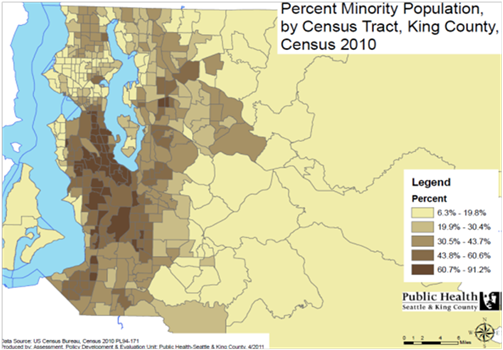

I'm not getting quite a color gradient as I would like, because of the really expensive outlier house prices. <br>
So now let's clean up by dropping these outliers

In [ ]:
df.sort_values('price',ascending=False).head(20)

In [ ]:
# Sample out top 1% of all houses
len(df)*(0.01)

In [ ]:
bottom_99_perc = df.sort_values('price',ascending=False).iloc[216:]

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='long',y='lat',
                data=bottom_99_perc,hue='price',
                palette='RdYlGn',edgecolor=None,alpha=0.2)

**Other features**

In [ ]:
# Whether or not house is in front of waterfront
sns.boxplot(x='waterfront',y='price',data=df)

**Working with feature data**

In [ ]:
df = df.drop('id', axis=1)

In [ ]:
# TO datetime object
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# New column Year
df['year'] = df['date'].apply(lambda date: date.year)

In [ ]:
# New column Month
df['month'] = df['date'].apply(lambda date:date.month)

See if whether house prices fluctuate seasonally

In [ ]:
# Monthly
plt.figure(figsize=(10,6))
sns.boxplot(x='month',y='price',data=df)

In [ ]:
# Mean Price varying throughout the months
df.groupby('month').mean()['price'].plot()

In [ ]:
# Mean Price varying throught the years
df.groupby('year').mean()['price'].plot()

In [ ]:
# Dropping the date
df = df.drop('date', axis=1)

In [ ]:
df.columns

Zipcode is numerical but not a continuous feature!! <br>
Zipcode mapping is hard and there is no clear continuous distribution of these actual zipcodes, so need to treat them as a categorical feature. 

In [ ]:
df['zipcode'].value_counts()

There are 70 different zipcodes in the data. It is not feasible to get_dummies 70 different categories. So, I will drop the zipcodes.

In [ ]:
df = df.drop('zipcode',axis=1)

In [ ]:
# could make sense due to scaling, higher should correlate to more value
df['yr_renovated'].value_counts()

The higher the value of this year renovated than the more likely that the House is going to have a higher sale price.<br>
And since 0 actually follows along with this correlation it's almost like the lowest year possible.<br>
Then we should expect that to also have little value.

In [ ]:
df['sqft_basement'].value_counts()

Same tihng goes for 'sqft_basement', where 0 means there is no basement

**Scaling and Train Test Split**

In [ ]:
X = df.drop('price',axis=1).values
y = df['price'].values

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)

**Scaling**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train = scaler.fit_transform(X_train)

In [ ]:
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

**Creating a model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()

model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [ ]:
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=128, epochs=400)
# smaller batch size, the longer the training is going to take, but the less likely that we are overfitting
# because we are not parsing in the entire training set at once, and only focusing on smaller batches

In [ ]:
model.history.history 
# returns a dictionary

In [ ]:
# But because we parsed in validation data tuple, and if we convert it to a df
# I will not only get Loss on training set, I will also get Loss on test set/ validation data

losses = pd.DataFrame(model.history.history)

In [ ]:
losses.plot()
# We want in decrease in both and no increase in the validation set
# If val_loss begin to spike, it means overfitting, because we will have a much larger loss on validation data

**Evaluation on test data**

In [ ]:
# MSE, MAE
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [ ]:
predictions = model.predict(X_test)

In [ ]:
predictions

In [ ]:
# MSE
mean_squared_error(y_test,predictions)

In [ ]:
# RMSE
np.sqrt(mean_squared_error(y_test,predictions))

In [ ]:
# MAE
mean_absolute_error(y_test,predictions)
# Off by $100,000
# Is that good or bad? Need to see the actual data itself

In [ ]:
df['price'].describe()

Mean is 540,000 dollars <br>
We are off by around 20%

In [ ]:
explained_variance_score(y_test, predictions)
# This tells us how much variance is being explained by our actual model
# Best score is 1, lower values are worse

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(y_test, predictions)
plt.plot(y_test,y_test, 'r')

In [ ]:
errors = y_test.reshape(6484, 1) - predictions

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(errors)

**Predicting on a brand new house**

In [ ]:
single_house = df.drop('price',axis=1).iloc[0]

In [ ]:
single_house = scaler.transform(single_house.values.reshape(-1,19))

In [ ]:
model.predict(single_house)

In [ ]:
df.head(1)

Predicting at 280,000 <br>
Selling at 222,000